In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [3]:
# Experiment configuration
experiment_name = "dpf_mass_friction"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [4]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel()
measurement_model = panda_models.PandaMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "dynamics_recurrent", "measurement"]
)

[buddy-dpf_mass_friction] Using device: cuda
[buddy-dpf_mass_friction] No checkpoint found


# Dynamics Model Pre-Training

In [13]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_varied_10.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_varied_10.hdf5",
    subsequence_length=32,
    **dataset_args
)

Parsed data: 1865 active, 525 inactive
Keeping: 525


In [11]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1)
    print()

buddy.save_checkpoint("phase_0_dynamics_pretrain")

Training epoch 0



Epoch loss: 0.00566867

Training epoch 1



Epoch loss: 0.0029910349

Training epoch 2



Epoch loss: 0.0027543204

Training epoch 3



Epoch loss: 0.0026194295

Training epoch 4



Epoch loss: 0.002573202

[buddy-dpf_mass_friction] Saved checkpoint to path: checkpoints/dpf_mass_friction-phase_0_dynamics_pretrain.ckpt


In [19]:
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=32, shuffle=True, num_workers=2)

for i in range(20):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2')
    print()

buddy.save_checkpoint("phase_1_dynamics_pretrain_recurrent")

Training epoch 0



Epoch loss: 0.0009621948

Training epoch 1



Epoch loss: 0.00084349205

Training epoch 2



Epoch loss: 0.00082835724

Training epoch 3



Epoch loss: 0.00082373206

Training epoch 4



Epoch loss: 0.00075707835

Training epoch 5



Epoch loss: 0.001025209

Training epoch 6



Epoch loss: 0.0007752275

Training epoch 7



Epoch loss: 0.000869418

Training epoch 8



Epoch loss: 0.00092999724

Training epoch 9



Epoch loss: 0.0007570253

Training epoch 10



Epoch loss: 0.0007756297

Training epoch 11



Epoch loss: 0.0007701971

Training epoch 12



Epoch loss: 0.0006929834

Training epoch 13



Epoch loss: 0.00062766706

Training epoch 14



Epoch loss: 0.00067988987

Training epoch 15



Epoch loss: 0.000638242

Training epoch 16



Epoch loss: 0.0006307412

Training epoch 17



Epoch loss: 0.00078399986

Training epoch 18



Epoch loss: 0.00070734584

Training epoch 19



Epoch loss: 0.0006302803

[buddy-dpf_mass_friction] Saved checkpoint to path: checkpoints/dpf_mass_friction-phase_1_dynamics_pretrain_recurrent.ckpt


# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_varied_10.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [ ]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=32,
    shuffle=True,
    num_workers=16)

for i in range(5):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()



In [ ]:
buddy.save_checkpoint("phase_2_measurement_pretrain")


# End-to-end Training

In [11]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_1000.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

Parsed data: 13331 active, 1669 inactive
Keeping (inactive): 1669


In [12]:
print(len(e2e_trainset.subsequences))

15000


In [13]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.0, 0.0, 0.0, 0.0)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(5):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

Training epoch 0



Epoch loss: 0.0010535392
Training epoch 1



Epoch loss: 0.0007841551
Training epoch 2



Epoch loss: 0.0009964929
Training epoch 3



Epoch loss: 0.0016213141
Training epoch 4



Epoch loss: 0.000905356


In [14]:
buddy.save_checkpoint("phase_3_end_to_end_trained")
buddy.save_checkpoint()

[buddy-dpf_feb19_new2] Saved checkpoint to path: checkpoints/dpf_feb19_new2-phase_3_end_to_end_trained.ckpt
[buddy-dpf_feb19_new2] Saved checkpoint to path: checkpoints/dpf_feb19_new2-0000000000183657.ckpt


# Model eval

In [21]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_varied_10.hdf5",
    **dataset_args
)

### Final Model

[buddy-dpf_mass_friction] Read checkpoint from path: checkpoints/dpf_mass_friction-phase_0_dynamics_pretrain.ckpt
[buddy-dpf_mass_friction] Loaded checkpoint at step: 375
phase_0_dynamics_pretrain


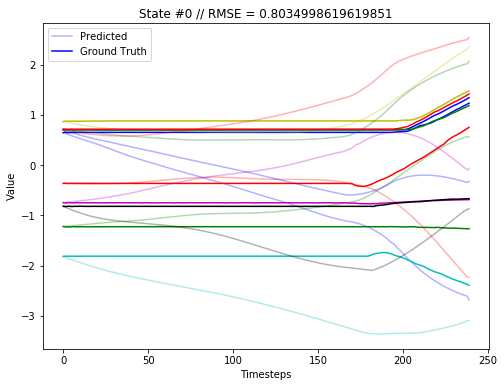

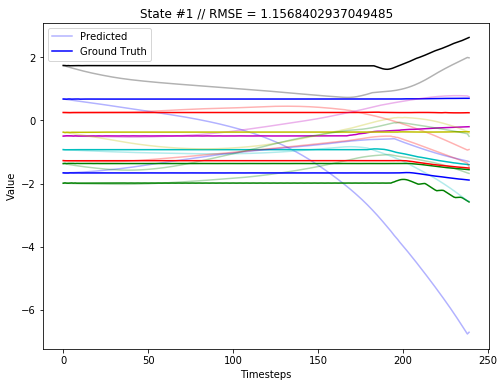

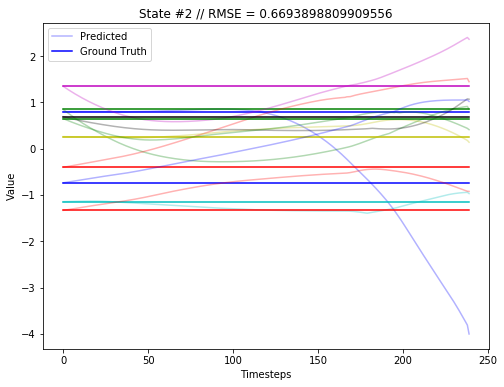

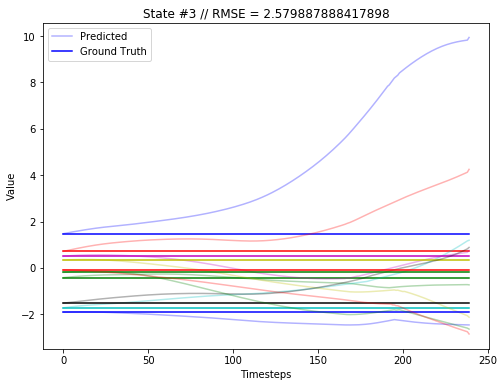

(0.0, 0.0, 0.0, 0.0)
[buddy-dpf_mass_friction] Read checkpoint from path: checkpoints/dpf_mass_friction-phase_1_dynamics_pretrain_recurrent.ckpt
[buddy-dpf_mass_friction] Loaded checkpoint at step: 633
phase_1_dynamics_pretrain_recurrent


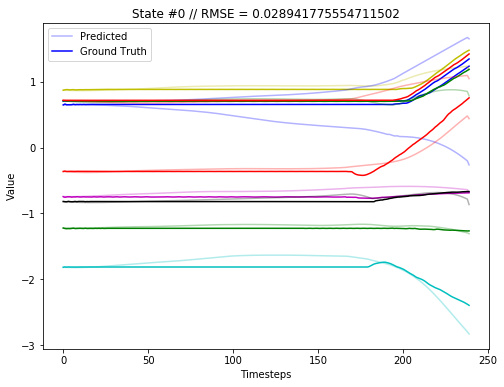

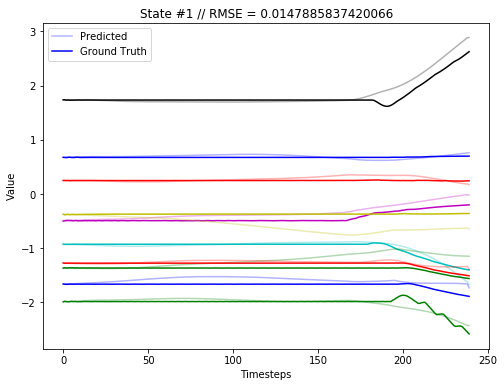

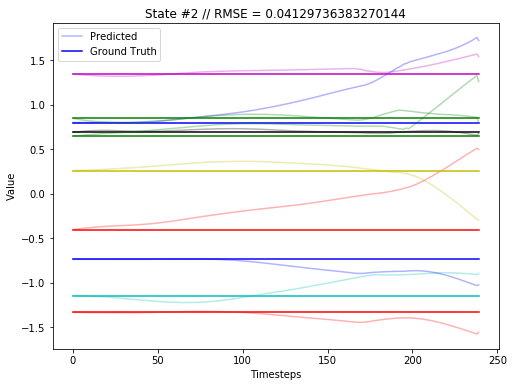

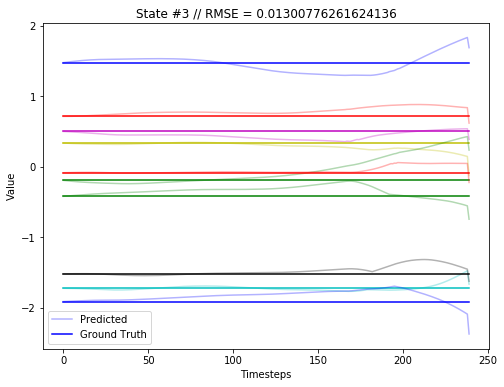

(0.0, 0.0, 0.0, 0.0)


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/dpf_mass_friction-phase_2_measurement_pretrain.ckpt'

In [26]:
phases = [
    'phase_0_dynamics_pretrain',
    'phase_1_dynamics_pretrain_recurrent',
    'phase_2_measurement_pretrain',
    'phase_3_end_to_end_trained'
]
for phase in phases:
    buddy.load_checkpoint(phase)
    print(phase)
    pf_model.dynamics_model.state_noise_stddev = (0.0, 0.0, 0.0, 0.0)
    pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
    panda_training.eval_rollout(pred, actual, plot=True)
    print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
# pf_model.dynamics_model.state_noise = (0.005, 0.005)


# # Back up model
# buddy.save_checkpoint()

# # Load the pre-end-to-end-training version of the model & evaluate
# buddy.load_checkpoint(label="before_e2e_training")

# pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
# panda_training.eval_rollout(pred, actual, plot=True)

# # Restore model
# buddy.load_checkpoint()

In [ ]:
buddy.save_checkpoint()